In [2]:
import anndata as ad

In [8]:
adata = ad.read_h5ad("../data/testdata/test4_qcplots/test4_input/adata_log2_cont_filter.h5ad")

<Axes: xlabel='total_bill', ylabel='Density'>

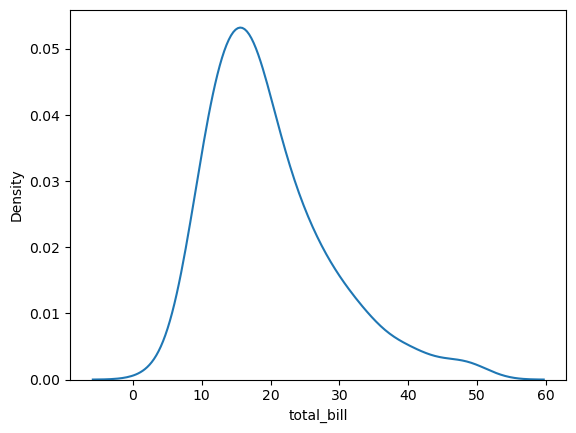

In [3]:
tips = sns.load_dataset("tips")
sns.kdeplot(data=tips, x="total_bill")

In [4]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


<Axes: xlabel='total_bill', ylabel='Density'>

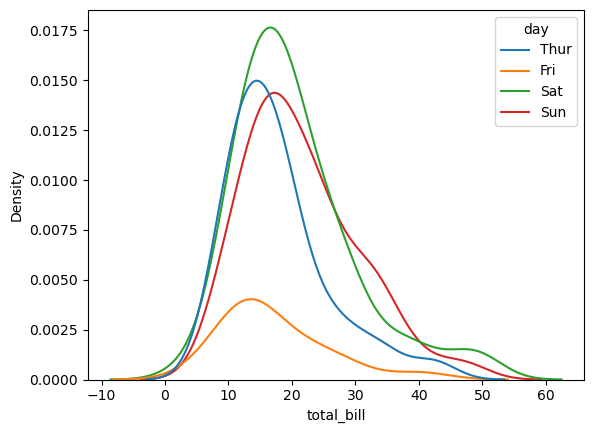

In [6]:
sns.kdeplot(data=tips, x="total_bill", hue="day")

In [9]:
#I will create a dataframe similar to tips from my adata

In [11]:
adata

AnnData object with n_obs × n_vars = 11 × 3244
    obs: 'Slide', 'Scene', 'Number of cells', 'Area µm^2', 'name_of_class', 'calibs', '384_software_well', 'Column', '384_hardware_well', 'samples_and_wells', 'well check', '96_well'
    var: 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description'

In [12]:
adata.obs

,Slide,Scene,Number of cells,Area µm^2,name_of_class,calibs,384_software_well,Column,384_hardware_well,samples_and_wells,well check,96_well
Name,,,,,,,,,,,,
Z:\Users\Jose\3_MassSpectrometry_Data\DVP16_P10_E01_MouseHearts\Olive_20230522_JoN_Hstdia_P10E01_control_region1_C3_1_2035.d,2,1,207,43055,control_region1,"calib1, calib2, calib3",C3,3,C4,"'control_region1':'C3',",good,C3
Z:\Users\Jose\3_MassSpectrometry_Data\DVP16_P10_E01_MouseHearts\Olive_20230522_JoN_Hstdia_P10E01_control_region2_C4_1_2038.d,2,2,201,34655,control_region2,"calib1, calib2, calib3",C5,5,C6,"'control_region2':'C5',",good,C4
Z:\Users\Jose\3_MassSpectrometry_Data\DVP16_P10_E01_MouseHearts\Olive_20230522_JoN_Hstdia_P10E01_control_region3_C5_1_2042.d,2,3,220,35634,control_region3,"calib1, calib2, calib3",C7,7,C8,"'control_region3':'C7',",good,C5
Z:\Users\Jose\3_MassSpectrometry_Data\DVP16_P10_E01_MouseHearts\Olive_20230522_JoN_Hstdia_P10E01_IZ_region1_D4_1_2036.d,1,1,223,43647,IZ_region1,"calib1, calib2, calib3",E5,5,E6,"'IZ_region1':'E5',",looks good,D4
Z:\Users\Jose\3_MassSpectrometry_Data\DVP16_P10_E01_MouseHearts\Olive_20230522_JoN_Hstdia_P10E01_IZ_region2_D5_1_2039.d,1,2,176,37099,IZ_region2,"calib1, calib2, calib3",E7,7,E8,"'IZ_region2':'E7',",looks good,D5
Z:\Users\Jose\3_MassSpectrometry_Data\DVP16_P10_E01_MouseHearts\Olive_20230522_JoN_Hstdia_P10E01_IZ_region3_D6_1_2043.d,1,3,227,36815,IZ_region3,"calib1, calib2, calib3",E9,9,E10,"'IZ_region3':'E9',",not so good,D6
Z:\Users\Jose\3_MassSpectrometry_Data\DVP16_P10_E01_MouseHearts\Olive_20230522_JoN_Hstdia_P10E01_IZ_region4_D3_1_2045.d,1,4,270,44048,IZ_region4,"calib1, calib2, calib3",E3,3,E4,"'IZ_region4':'E3',","yes, some",D3
Z:\Users\Jose\3_MassSpectrometry_Data\DVP16_P10_E01_MouseHearts\Olive_20230522_JoN_Hstdia_P10E01_remote_region_1_E5_1_2037.d,1,1,80,15724,remote_region_1,"calib1, calib2, calib3",G3,3,G4,"'remote_region_1':'G3',",4/10,E5
Z:\Users\Jose\3_MassSpectrometry_Data\DVP16_P10_E01_MouseHearts\Olive_20230522_JoN_Hstdia_P10E01_remote_region_2_E4_1_2040.d,1,2,145,25241,remote_region_2,"calib1, calib2, calib3",G5,5,G6,"'remote_region_2':'G5',",good,E4


In [13]:
df = pd.DataFrame(data=adata.X.T, columns=adata.obs.name_of_class, index=adata.var_names)

name_of_class,control_region1,control_region2,control_region3,IZ_region1,IZ_region2,IZ_region3,IZ_region4,remote_region_1,remote_region_2,remote_region_3,remote_region_4
Protein.Group,,,,,,,,,,,
A0A075B5M7;A0A0B4J1J2;A0A0B4J1J1,10.417705,12.909089,11.531937,14.753812,11.034084,14.137816,12.143039,12.323179,NaN,13.100763,NaN
A0A075B5N2;P01657;P01634;A0A140T8P2;P01632,11.763727,NaN,11.982562,12.129238,12.457173,12.414643,12.097752,11.876379,12.166038,12.167957,12.470415
A0A075B5R5,10.376755,NaN,9.741512,11.771114,11.163310,10.920956,NaN,9.876752,10.077029,10.256492,10.899168
A0A075B5U6;P06330;A0A075B5V0;A0A075B5V1;A0A075B5V2;A0A075B5U7;A0A075B5V6;A0A075B5V7,NaN,NaN,10.023546,11.774734,10.417937,12.117497,11.000289,10.870080,10.410610,9.828197,NaN
A0A087WQY2,12.870332,13.548280,13.310499,13.670424,13.798350,14.026204,14.141469,13.666135,13.899376,13.677632,13.946303
...,...,...,...,...,...,...,...,...,...,...,...
Q9Z2Z6,16.830094,17.032573,16.822334,16.580771,16.425855,16.533372,15.702062,16.747078,16.435055,16.758926,16.730457
Q9Z2Z9,NaN,9.478816,NaN,12.712114,13.115645,12.989579,12.168374,12.111113,12.235778,11.832293,12.802454
Q9Z315,11.037025,10.662677,10.227171,11.114256,11.280904,10.857585,11.843368,10.911519,10.721373,10.250346,NaN


In [17]:
df.columns

Index(['control_region1', 'control_region2', 'control_region3', 'IZ_region1',
       'IZ_region2', 'IZ_region3', 'IZ_region4', 'remote_region_1',
       'remote_region_2', 'remote_region_3', 'remote_region_4'],
      dtype='object', name='name_of_class')

In [18]:
df = pd.melt(df, var_name="sample_id", value_name='values', col_level=None, ignore_index=True)

In [19]:
df

,sample_id,values
0,control_region1,10.417705
1,control_region1,11.763727
2,control_region1,10.376755
3,control_region1,NaN
4,control_region1,12.870332
...,...,...
35679,remote_region_4,16.730457
35680,remote_region_4,12.802454
35681,remote_region_4,NaN
35682,remote_region_4,13.415742


<Axes: xlabel='values', ylabel='Density'>

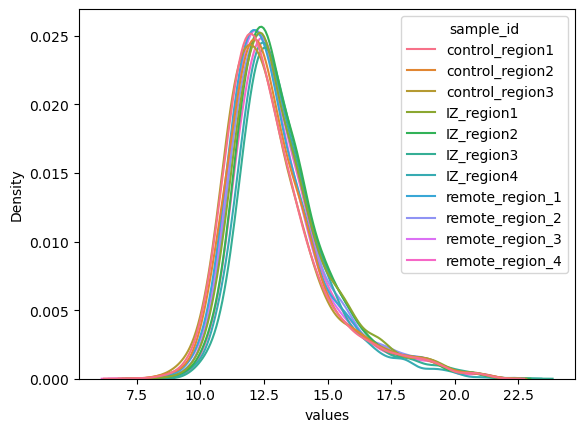

In [20]:
sns.kdeplot(data=df, x="values", hue="sample_id")